## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

import sys
sys.path.append('/home/jcollins')

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params, \
                                              jack_1_template, jack_vae_template_2, jack_vae_template_1, jack_vae_template_test
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetVarAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [4]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_vae_bneck-100-withbrenorm-1'
n_pc_points = 1000                # Number of points per model.
bneck_size = 100                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

Load Point-Clouds

In [5]:
import pandas as pd
n_pc_points = 1000
numjets = 100000
numvalid = 10000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top_unnormalized_1.h5")
traindata = outstore.select("points",stop=numjets).values
traindata = traindata.reshape(numjets,1000,2)
train_pc_data = PointCloudDataSet(traindata,copy=False)
validdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
validdata = validdata.reshape(numvalid,1000,2)
valid_pc_data = PointCloudDataSet(validdata,copy=False)



gc.collect()

67

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
train_params = default_train_params()
train_params['saver_step'] = 2
#train_params['learning_rate'] = 0.0001

In [7]:
encoder, decoder, enc_args, dec_args = jack_vae_template_1(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [8]:
conf = Conf(n_input = [n_pc_points, 2],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args,
            beta=0.0
           )
conf.experiment_name = experiment_name
conf.held_out_step = 1   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

Build AE Model.

In [9]:
reset_tf_graph()
ae = PointNetVarAutoEncoder(conf.experiment_name, conf)

Building Encoder
encoder_conv_layer_0 conv params =  384 Tensor("Relu:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 Tensor("Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("Mean:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 Tensor("Relu_2:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 Tensor("encoder_dense_layer_1_bnorm/batchnorm/add_1:0", shape=(?, 128), dtype=float32)
output size: 128 

[<tf.Tensor 'z_mean/BiasAdd:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'z_log_var/BiasAdd:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'z/add:0' shape=(?, 100) dtype=float32>]
Building Decoder
decoder_dense_layer_0 FC params =  12928 bnorm params =  256
Tensor("single_class_vae_bneck-100-withbrenorm-1_2/Relu:0", shape=(?, 128), dtype=float32)
output size: 128 

decoder_dense_layer_1 FC params =  48375 bnorm params =  7

Train the AE (save output to train_stats.txt) 

If you ran the above lines, you can reload a saved model like this:

In [10]:
load_pre_trained_ae = True
restore_epoch = 100
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetVarAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  384 Tensor("Relu:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 Tensor("Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("Mean:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 Tensor("Relu_2:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 Tensor("encoder_dense_layer_1_bnorm/batchnorm/add_1:0", shape=(?, 128), dtype=float32)
output size: 128 

[<tf.Tensor 'z_mean/BiasAdd:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'z_log_var/BiasAdd:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'z/add:0' shape=(?, 100) dtype=float32>]
Building Decoder
decoder_dense_layer_0 FC params =  12928 bnorm params =  256
Tensor("single_class_vae_bneck-100-withbrenorm-1_2/Relu:0", shape=(?, 128), dtype=float32)
output size: 128 

decoder_dense_layer_1 FC params =  48375 bnorm params =  7

Get a batch of reconstuctions and their latent-codes.

Use any plotting mechanism such as matplotlib to visualize the results.

In [11]:
import ot
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

In [14]:
numload = 100
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
z_means, z_log_vars, z_sampled = ae.transform(feed_pc)

In [15]:
recon, loss = ae.partial_fit(feed_pc, beta = 1, GT=None)
print(loss)

275.70044


0


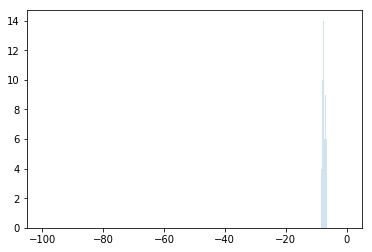

1


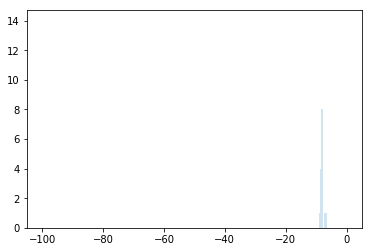

2


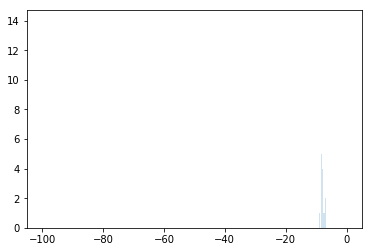

3


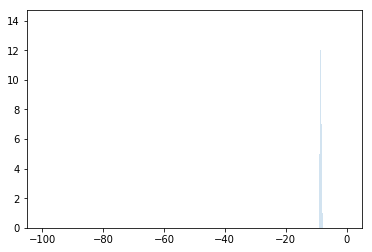

4


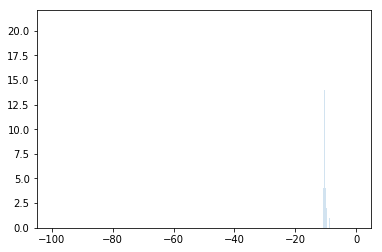

5


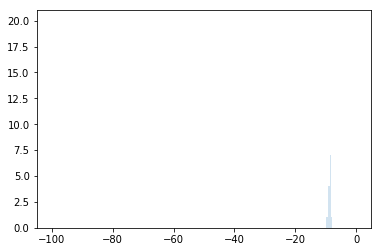

6


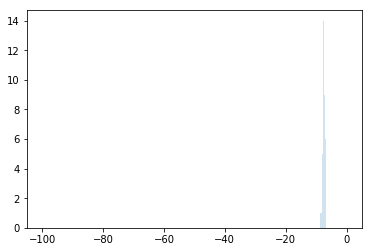

7


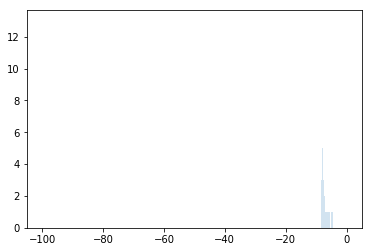

8


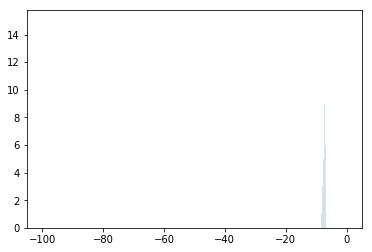

9


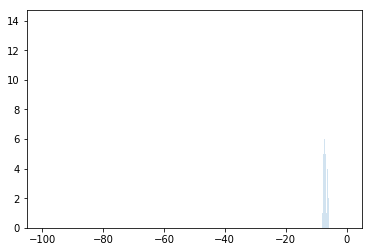

10


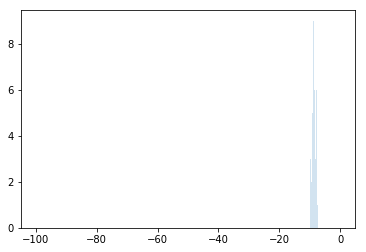

11


KeyboardInterrupt: 

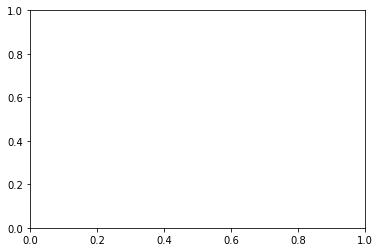

In [16]:
for i,dataset in enumerate(z_log_vars.T[:100]):
    print(i)
    plt.hist(dataset,bins=np.arange(-100,0.1,0.1),alpha=0.2)
    plt.show()

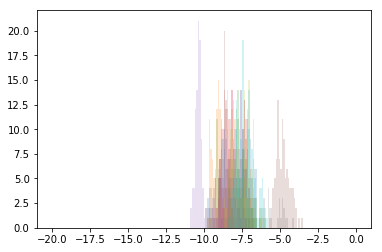

In [19]:
for dataset in z_log_vars.T[:20]:
    plt.hist(dataset,bins=np.arange(-20,0.1,0.1),alpha=0.2)
plt.show()

In [39]:
traindata[0]

array([[ 0.97368664, -0.71363292],
       [ 0.97368664, -0.71363292],
       [ 0.97368664, -0.71363292],
       ...,
       [ 1.0140427 , -0.37483655],
       [ 1.0140427 , -0.37483655],
       [ 1.0140427 , -0.37483655]])

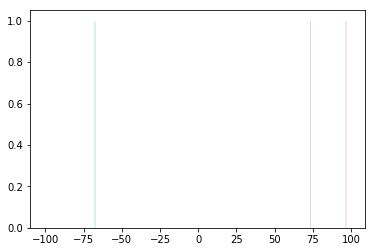

In [35]:
for dataset in z_means.T[:20]:
    plt.hist(dataset,bins=np.arange(-100,100,1.),alpha=0.2)
plt.show()

In [26]:
ae.transform(feed_pc)[0].shape

(1000, 100)

In [22]:
numload = 1000
latent_codes = np.zeros((0,100))
for i in range(-10,10):dd
    feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
    latent_codes = np.append(latent_codes,ae.transform(feed_pc),axis=0)


plt.hist2d(latent_codes[:,0],latent_codes[:,1],norm=LogNorm(0.5, 1000),bins=20, range = [[-1,1],[-1,1]])
plt.show()

ValueError: all the input arrays must have same number of dimensions

In [33]:
numload = 100
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

In [36]:
ae.reconstruct(feed_pc)

IndexError: tuple index out of range

In [ ]:
def jet_masses(jets, p_norm = 600):
    numpoints = len(jets[0])
    Delta_Rs = np.linalg.norm(feed_pc,axis=2)
#    p_parr = np.sum(np.cos(Delta_Rs),axis=1)
    p_parr = np.sum(np.cos(jets[:,:,0])*np.cos(jets[:,:,1]),axis=1)
    masses = np.sqrt(numpoints**2 - np.power(p_parr,2))*p_norm/numpoints
    return masses

In [ ]:
codes_xy = np.arange(0,1.1,0.2)
np.array([[[codes_xy[i], codes_xy[j]] for i in range(len(codes_xy))] for j in range(len(codes_xy))]).reshape(-1,2)

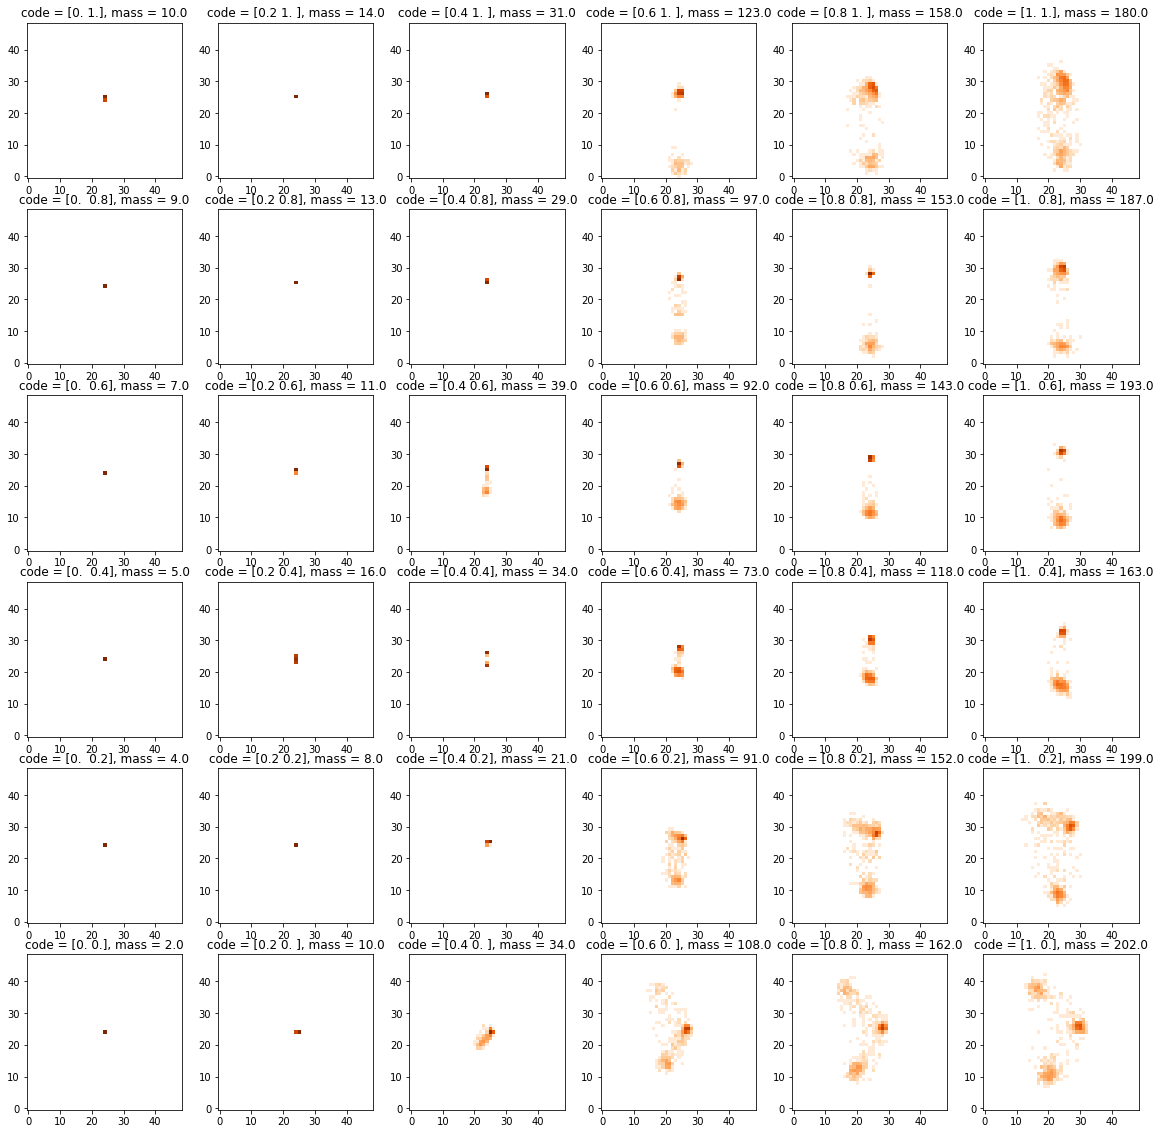

In [111]:
lim=0.8
bins=np.linspace(-lim, lim, 50)
#codes = np.array([0.45,0.7,1])
codes_xy = np.arange(0,1.1,0.2)
codes = np.array([[[codes_xy[i], codes_xy[5-j]] for i in range(len(codes_xy))] for j in range(len(codes_xy))]).reshape(-1,2)
temp_reconstructions=ae.decode(codes)

plt.figure(figsize=[20,20])

jet_ms = jet_masses(temp_reconstructions)

for i, reconstruction in enumerate(temp_reconstructions):
    plt.subplot(6,6,i+1)
    counts, bx, by = np.histogram2d(reconstruction[:,0],reconstruction[:,1],bins=bins)
    #print codes[i]
    plt.imshow(counts.T, norm=LogNorm(0.5, 1000), origin='lower',cmap='Oranges')
    plt.title("code = " + str(codes[i]) +  ", mass = " + str(round(jet_ms[i])))
plt.show()

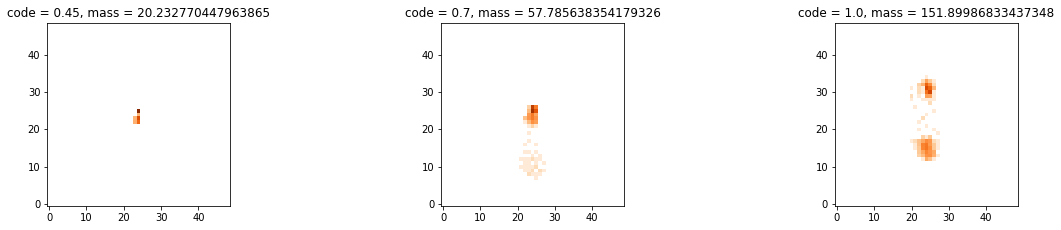

In [18]:
lim=0.8
bins=np.linspace(-lim, lim, 50)
codes = np.array([0.45,0.7,1])
#codes = np.arange(0.4,1.5,0.05)
temp_reconstructions=ae.decode(codes.reshape(-1,1))

plt.figure(figsize=[20,80])

jet_ms = jet_masses(temp_reconstructions)

for i, reconstruction in enumerate(temp_reconstructions):
    plt.subplot(20,3,i+1)
    counts, bx, by = np.histogram2d(reconstruction[:,0],reconstruction[:,1],bins=bins)
    #print codes[i]
    plt.imshow(counts.T, norm=LogNorm(0.5, 1000), origin='lower',cmap='Oranges')
    plt.title("code = " + str(codes[i]) +  ", mass = " + str(jet_ms[i]))
plt.show()

In [101]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch


print "##### Approx EMD #####"
nclouds = 1
npoints = 1000
ndim=2

points1 = reconstructions[:10]
points2 = feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)/1000*600
    print np.array(cost)
    
print time.time()-start


print "\n \n \n ##### True EMD #####"
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print time.time()-start
print truecost

print "\n \n \n ##### Fractional difference #####"
print (np.array(cost) - np.array(truecost))/np.array(truecost)

##### Approx EMD #####
[81.811104 57.385998 42.4408   31.419598 17.954147 29.520521 47.88909
 54.286137 22.82027  41.508293]
3.66719794273

 
 
 ##### True EMD #####
1.68018603325
[75.07462589 56.59483998 42.21813977 29.98111    17.60743652 29.26905909
 44.23036638 53.78889053 22.61921665 38.94040913]

 
 
 ##### Fractional difference #####
[0.08973042 0.01397933 0.00527403 0.0479798  0.01969116 0.0085914
 0.08271976 0.0092444  0.00888863 0.06594394]


In [13]:
from latent_3d_points.external.structural_losses import tf_approxmatch

In [43]:
xyz1 = tf.placeholder(tf.float32,shape=[None,2,2])
xyz2 = tf.placeholder(tf.float32,shape=[None,2,2])
match = tf_approxmatch.approx_match(xyz1,xyz2)
matchcost = tf_approxmatch.match_cost(xyz1,xyz2,match)
matchcostgrad = tf_approxmatch.approxmatch_module.match_cost_grad(xyz1,xyz2,match)
xyz1repl = np.array([[[0,0.],[0,0.]]])
xyz2repl = np.array([[[5*np.pi+0.1,0],[0.1,0.1]]])
tf.Session().run([matchcost,matchcostgrad,tf.gradients(matchcost,xyz2)],
         feed_dict={xyz1:xyz1repl,
                    xyz2:xyz2repl})

[array([3.1830142], dtype=float32),
 MatchCostGrad(grad1=array([[[-0.14644678, -0.35355356],
        [-0.14644678, -0.35355356]]], dtype=float32), grad2=array([[[-1.       ,  0.       ],
        [ 0.7071064,  0.7071071]]], dtype=float32)),
 [array([[[-1.       ,  0.       ],
          [ 0.7071064,  0.7071071]]], dtype=float32)]]

In [50]:
xyz1 = tf.placeholder(tf.float32,shape=[None,2,2])
xyz2 = tf.placeholder(tf.float32,shape=[None,2,2])
match = tf_approxmatch.approx_match(xyz1,xyz2)
matchcost = tf_approxmatch.match_cost(xyz1,xyz2,match)
matchcostgrad = tf_approxmatch.approxmatch_module.match_cost_grad(xyz1,xyz2,match)
xyz1repl = np.array([[[0,0.],[0.0,0.0]]])
xyz2repl = np.array([[[-0.1,0],[0.1,0.1]]])
tf.Session().run([match,matchcost,matchcostgrad,tf.gradients(matchcost,xyz2)],
         feed_dict={xyz1:xyz1repl,
                    xyz2:xyz2repl})

[array([[[0.5, 0.5],
         [0.5, 0.5]]], dtype=float32),
 array([0.2414212], dtype=float32),
 MatchCostGrad(grad1=array([[[-0.14644678, -0.35355356],
        [-0.14644678, -0.35355356]]], dtype=float32), grad2=array([[[-1.       ,  0.       ],
        [ 0.7071064,  0.7071071]]], dtype=float32)),
 [array([[[-1.       ,  0.       ],
          [ 0.7071064,  0.7071071]]], dtype=float32)]]

In [97]:
tf.gradients(matchcost,xyz2)

[<tf.Tensor 'gradients/MatchCost_3_grad/mul_1:0' shape=(?, 1, 2) dtype=float32>]

In [85]:
sess.run(tf_approxmatch.approx_match(xyz1,xyz2))

ValueError: Fetch argument <tf.Tensor 'ApproxMatch_11:0' shape=(1, 1, 1) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("ApproxMatch_11:0", shape=(1, 1, 1), dtype=float32) is not an element of this graph.)

In [32]:
np.linspace(-lim, lim, 100)

array([-5.        , -4.8989899 , -4.7979798 , -4.6969697 , -4.5959596 ,
       -4.49494949, -4.39393939, -4.29292929, -4.19191919, -4.09090909,
       -3.98989899, -3.88888889, -3.78787879, -3.68686869, -3.58585859,
       -3.48484848, -3.38383838, -3.28282828, -3.18181818, -3.08080808,
       -2.97979798, -2.87878788, -2.77777778, -2.67676768, -2.57575758,
       -2.47474747, -2.37373737, -2.27272727, -2.17171717, -2.07070707,
       -1.96969697, -1.86868687, -1.76767677, -1.66666667, -1.56565657,
       -1.46464646, -1.36363636, -1.26262626, -1.16161616, -1.06060606,
       -0.95959596, -0.85858586, -0.75757576, -0.65656566, -0.55555556,
       -0.45454545, -0.35353535, -0.25252525, -0.15151515, -0.05050505,
        0.05050505,  0.15151515,  0.25252525,  0.35353535,  0.45454545,
        0.55555556,  0.65656566,  0.75757576,  0.85858586,  0.95959596,
        1.06060606,  1.16161616,  1.26262626,  1.36363636,  1.46464646,
        1.56565657,  1.66666667,  1.76767677,  1.86868687,  1.96

In [52]:
reconstructions[:,:,0] = np.mod(reconstructions[:,:,0]+np.pi,2*np.pi)-np.pi

In [43]:
reconstructions[12]

array([[41.793518  ,  0.5640073 ],
       [42.51293   ,  0.47025776],
       [42.365234  ,  1.086246  ],
       ...,
       [42.430733  ,  0.81698775],
       [42.42978   ,  0.79243857],
       [42.185936  ,  0.83409566]], dtype=float32)

In [30]:
feed_pc[0]

array([[-1.77030349,  0.4676643 ],
       [-1.77030349,  0.4676643 ],
       [-1.77030349,  0.4676643 ],
       ...,
       [-1.16792515,  0.67233879],
       [-1.16792515,  0.67233879],
       [-1.16792515,  0.67233879]])

In [32]:
reconstructions[0]

array([[ 0.79865503, -0.22795632],
       [ 1.0072377 , -0.14852503],
       [ 0.64558613, -0.54770565],
       ...,
       [ 0.8766489 , -0.27920833],
       [ 1.0309498 ,  0.04436365],
       [ 1.000967  , -0.10502619]], dtype=float32)

434.455769501


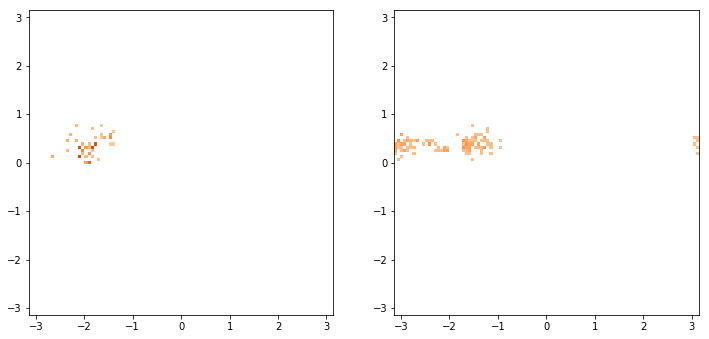

623.617369257


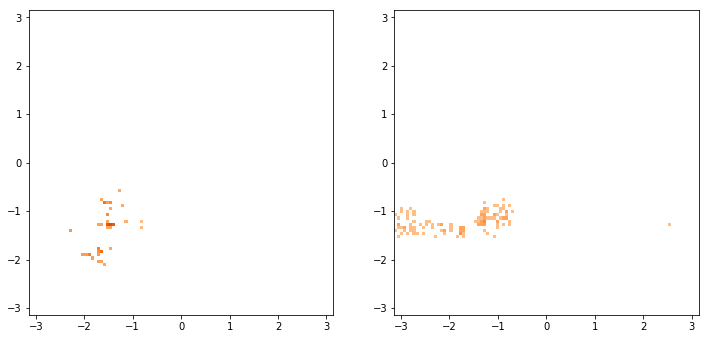

129.934071782


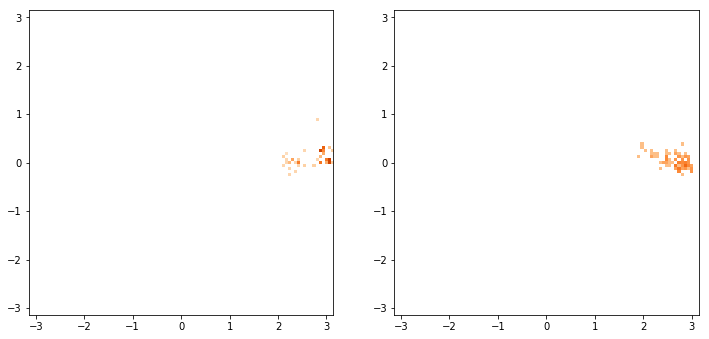

599.16232491


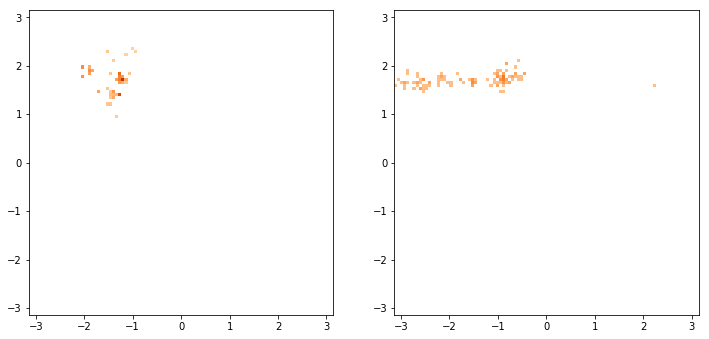

548.14897823


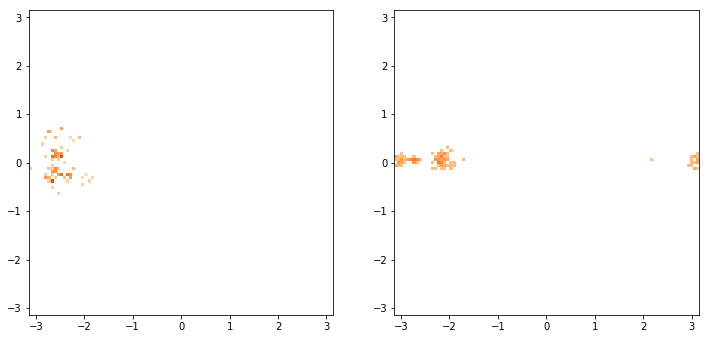

166.431065324


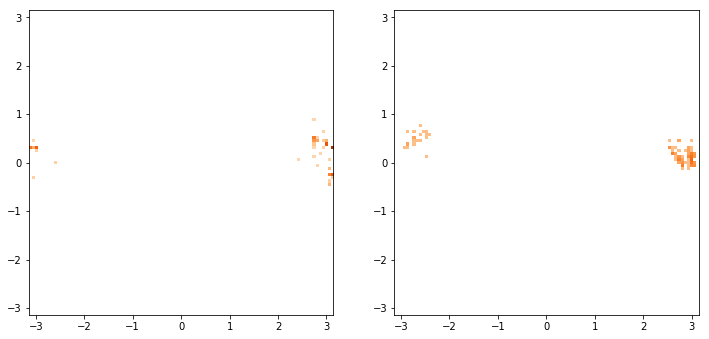

74.9196949369


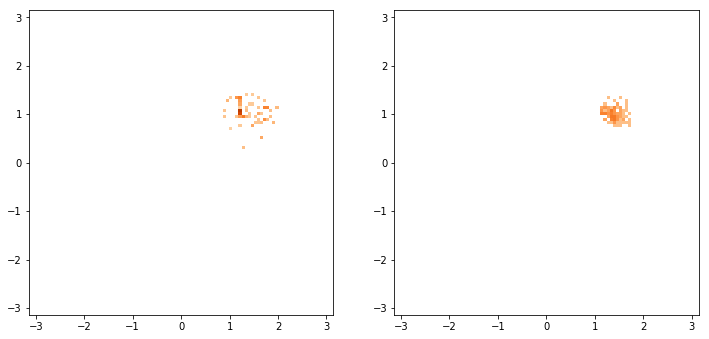

97.332392001


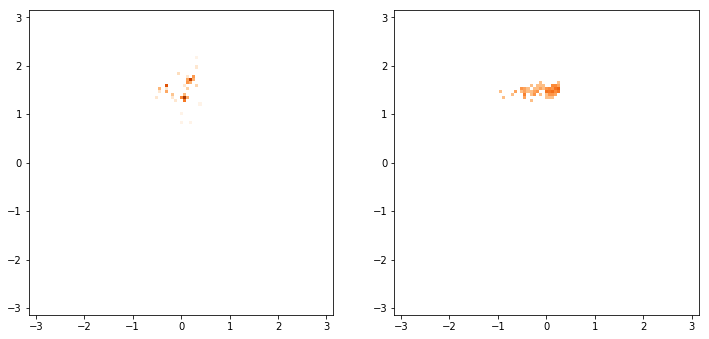

221.981320258


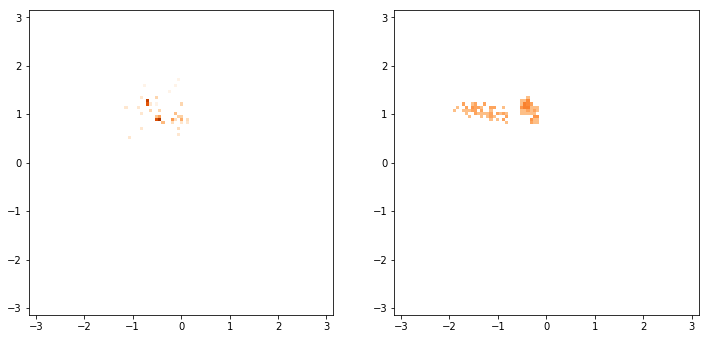

507.105498519


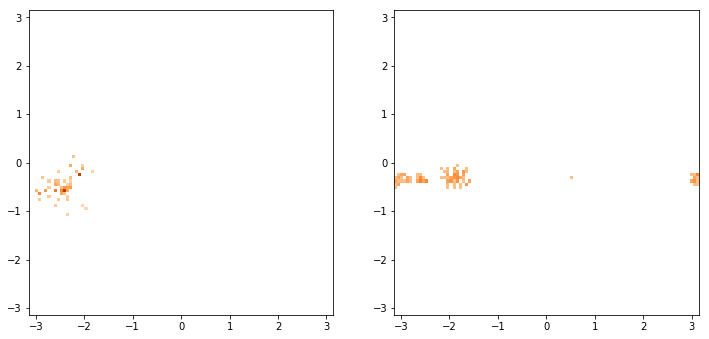

123.248649318


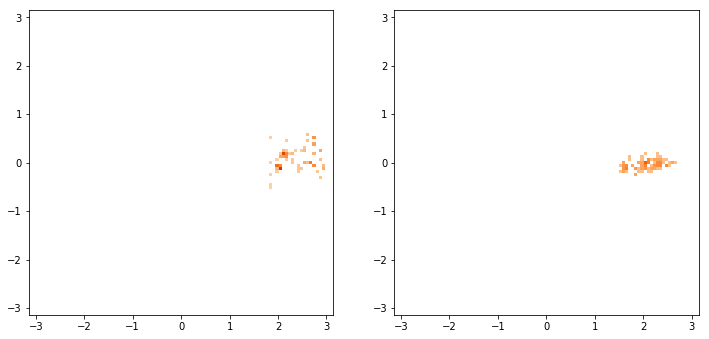

155.760033237


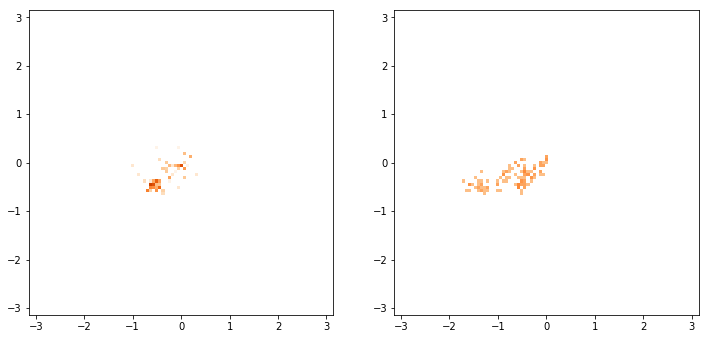

90.551226201


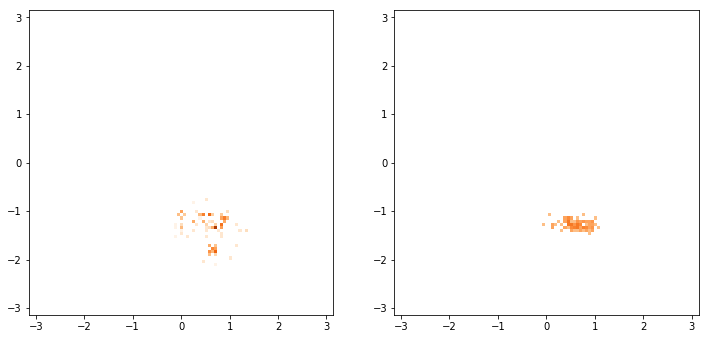

67.1915492931


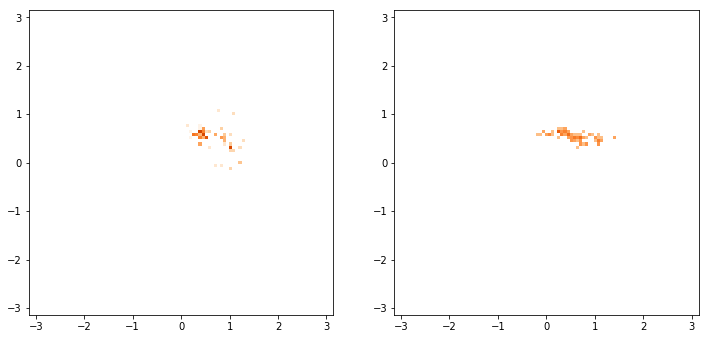

77.656010846


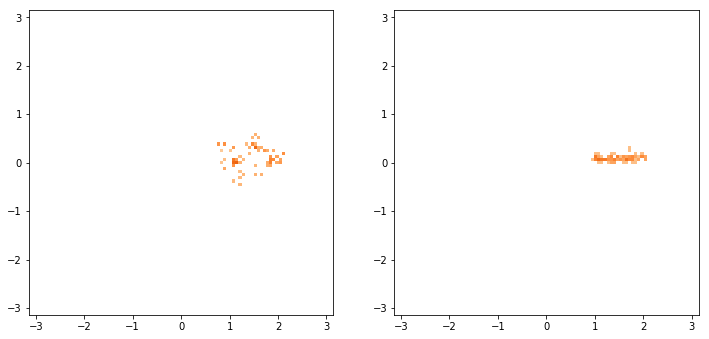

69.4367618813


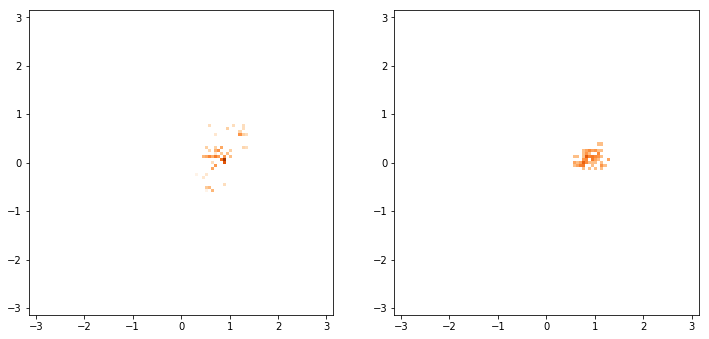

234.272488419


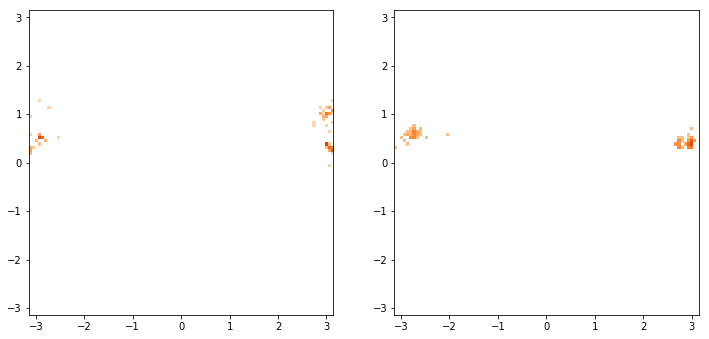

84.0491338724


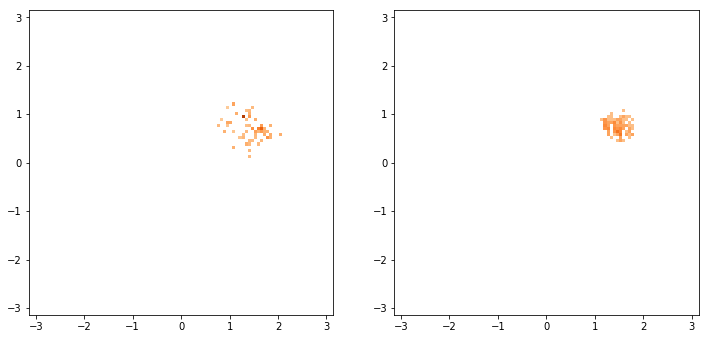

112.424430883


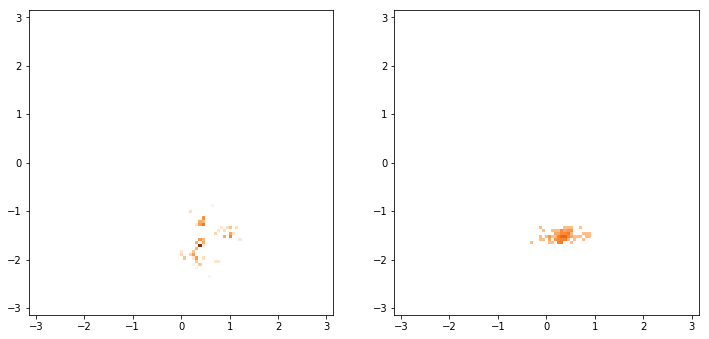

78.7543368705


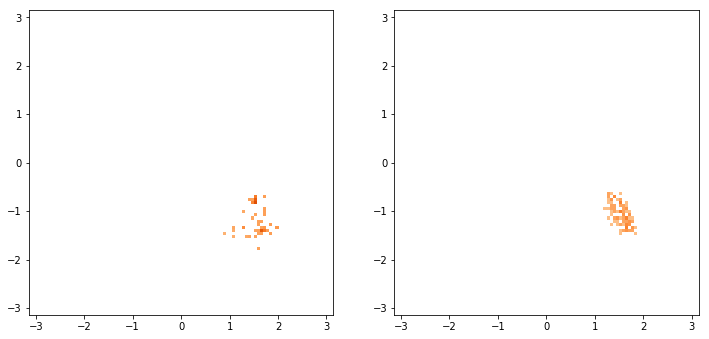

In [37]:
countcut=0.9
lim=np.pi
bins=np.linspace(-lim, lim, 100)

#for i in range(len(feed_pc)):
for i in range(0,20):   

    M = np.sqrt(ot.dist(feed_pc[i],reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)/1000*500

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[12,6])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    ax[0].imshow(counts.T , norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    ax[0].axvline(3.14,linewidth=0.5, color='black')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(np.mod(np.pi+reconstructions[i,:,0],2*np.pi)-np.pi,reconstructions[i][:,1],bins=bins)
    ax[1].imshow(counts.T, norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    plt.show()

In [105]:
import time
points1 = reconstructions[:100]
points2 = feed_pc[:100]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

qcd_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print qcd_truecost
print time.time()-start

print np.average(qcd_truecost)
print np.std(qcd_truecost)

[75.07462589 56.59483998 42.21813977 29.98111    17.60743652 29.26905909
 44.23036638 53.78889053 22.61921665 38.94040913 11.0146198  58.48786779
 35.10435213 44.75039082 17.64397472 41.23235729 12.16824136  7.42036687
 30.34516555 39.58170748 40.88762488 20.45590575 16.7558164  17.43403559
 19.83347945 23.14521052 39.10715683 51.91705182 43.43254131 37.39027438
 17.95735649 92.67533288 15.50884697 24.08738266 42.56493747 80.18168389
 34.37575292 67.37336177 67.9504303  60.89538383 55.73237276 86.31614223
 31.48024747 83.45726199 66.72014241 16.2673117   9.21094226 19.93969679
 36.58169053 26.42489868 24.59880662 48.06636576 50.30116624 28.14479361
 69.66059955 18.40395326 28.08811332 28.32299312 11.0570396  64.34625717
 22.95063903 18.55958876 22.99913801 29.17480983 37.2018918  16.75521239
 51.61739273 42.60858388 60.27166046 25.36606832 55.87213338 60.04971272
 14.98368623 17.67129109 17.08163441 26.67722976 36.18497717 37.07946846
 43.08057645 36.57171829 49.53001533 13.66398629 27

In [106]:
import pandas as pd
numjets = 0
numvalid = 10000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top.h5")
topdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
topdata = topdata.reshape(numvalid,1000,2)
top_pc_data = PointCloudDataSet(topdata,copy=False)
gc.collect()


numload = 1000
top_feed_pc, feed_model_names, _ = top_pc_data.next_batch(numload )
top_reconstructions = ae.reconstruct(top_feed_pc)[0]
top_latent_codes = ae.transform(top_feed_pc)

67.1590192909


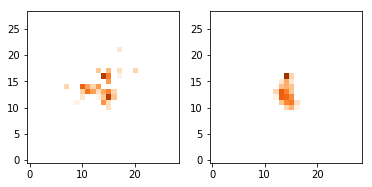

32.9848128951


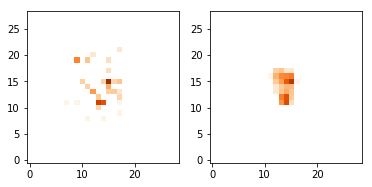

43.5306045562


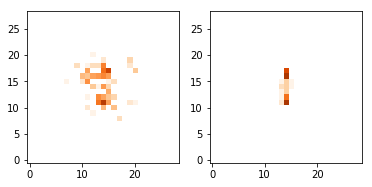

96.9595536488


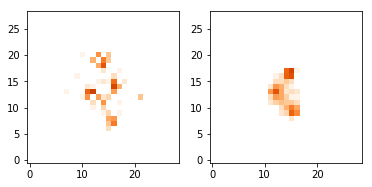

56.5107807271


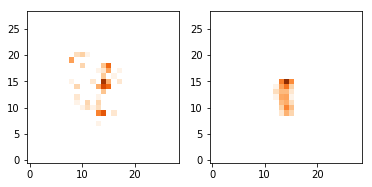

31.1558567445


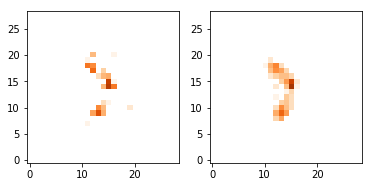

28.482677467


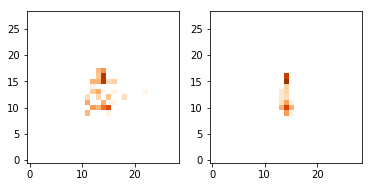

50.0595193685


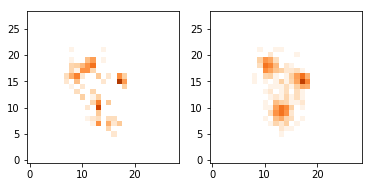

111.557907183


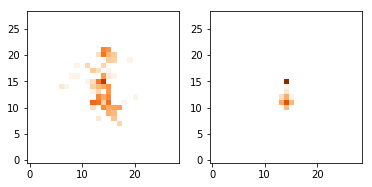

86.6148343221


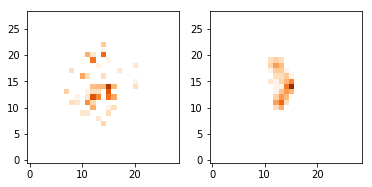

In [107]:
countcut=0.9
lim=1.5
bins=np.linspace(-lim, lim, 30)

#for i in range(len(feed_pc)):
for i in range(10):   

    M = np.sqrt(ot.dist(top_feed_pc[i],top_reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)/1000*500

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[6,3])
    counts, bx, by = np.histogram2d(top_feed_pc[i][:,0],top_feed_pc[i][:,1],bins=bins)
    ax[0].imshow(counts.T , norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(top_reconstructions[i][:,0],top_reconstructions[i][:,1],bins=bins)
    ax[1].imshow(counts.T, norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [108]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch


print "##### Approx EMD #####"
nclouds = 1
npoints = 1000
ndim=2

points1 = top_reconstructions[:10]
points2 = top_feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)/1000*600
    print np.array(cost)
    
print time.time()-start


print "\n \n \n ##### True EMD #####"
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print time.time()-start
print truecost

print "\n \n \n ##### Fractional difference #####"
print (np.array(cost) - np.array(truecost))/np.array(truecost)

##### Approx EMD #####
[ 85.88746   45.76537   57.824436 127.84058   77.66613   44.46702
  37.862076  70.76115  139.55957  116.11902 ]
3.83007621765

 
 
 ##### True EMD #####
1.67375588417
[ 80.59082315  39.58177547  52.23672547 116.35146438  67.81293687
  37.38702809  34.17921296  60.07142324 133.86948862 103.93780119]

 
 
 ##### Fractional difference #####
[0.06572257 0.15622326 0.10696901 0.09874495 0.14529961 0.18937023
 0.10775154 0.17795023 0.04250469 0.11719718]


In [109]:
import time
points1 = reconstructions[:1000]
points2 = feed_pc[:1000]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

qcd_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print qcd_truecost
print time.time()-start

print np.average(qcd_truecost)
print np.std(qcd_truecost)

import time
points1 = top_reconstructions[:1000]
points2 = top_feed_pc[:1000]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

top_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print top_truecost
print time.time()-start

print np.average(top_truecost)
print np.std(top_truecost)

[ 75.07462589  56.59483998  42.21813977  29.98111     17.60743652
  29.26905909  44.23036638  53.78889053  22.61921665  38.94040913
  11.0146198   58.48786779  35.10435213  44.75039082  17.64397472
  41.23235729  12.16824136   7.42036687  30.34516555  39.58170748
  40.88762488  20.45590575  16.7558164   17.43403559  19.83347945
  23.14521052  39.10715683  51.91705182  43.43254131  37.39027438
  17.95735649  92.67533288  15.50884697  24.08738266  42.56493747
  80.18168389  34.37575292  67.37336177  67.9504303   60.89538383
  55.73237276  86.31614223  31.48024747  83.45726199  66.72014241
  16.2673117    9.21094226  19.93969679  36.58169053  26.42489868
  24.59880662  48.06636576  50.30116624  28.14479361  69.66059955
  18.40395326  28.08811332  28.32299312  11.0570396   64.34625717
  22.95063903  18.55958876  22.99913801  29.17480983  37.2018918
  16.75521239  51.61739273  42.60858388  60.27166046  25.36606832
  55.87213338  60.04971272  14.98368623  17.67129109  17.08163441
  26.677229

[ 80.59082315  39.58177547  52.23672547 116.35146438  67.81293687
  37.38702809  34.17921296  60.07142324 133.86948862 103.93780119
  62.01026564  73.49715593  53.96829432  49.11399169  49.89957878
  64.34541473  64.11943537  64.45984485  60.33892626  58.95238363
  75.36776392  65.85201998  41.37665215  64.24517156  88.85586262
  77.76082408  56.83132698  97.69397598  77.19346311  72.65693647
  55.94546356 127.19154642  70.74041979  57.55997759  47.08260976
  74.42275471  59.19544244  72.54801334 115.12985161  55.8889974
  51.35890498  52.33906969  81.60037862  94.94452496  66.52158567
  34.48066381  53.27900728  53.72140808  46.16394525  46.96410383
  75.45240992  45.30231187  78.99344902  76.31675518  72.3091096
  93.54647164  56.11302072  46.23586556  54.0249273   64.23281609
  60.6494446   55.75252769  63.99031554  67.59850251  46.76216406
  42.16104063  63.48464633  60.99538708  48.13322728  43.36716451
  48.24410823  57.42884523  52.27953389  54.28778835  72.62123582
  55.0635336

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


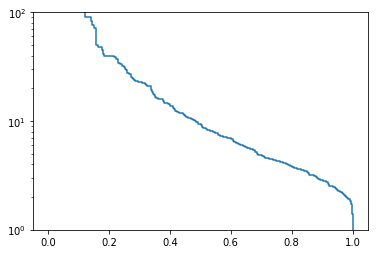

In [110]:
from sklearn.metrics import roc_curve

y_true = np.append(np.zeros(len(qcd_truecost)),np.ones(len(top_truecost)))
y_score = np.append(qcd_truecost, top_truecost)
my_roc = roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

plt.plot(my_roc[1],np.nan_to_num(1/my_roc[0]))
plt.ylim([1,10**2])
plt.semilogy()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.


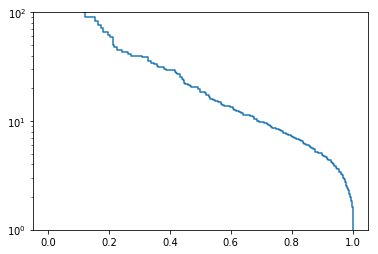

In [110]:



from sklearn.metrics import roc_curve

y_true = np.append(np.zeros(len(qcd_truecost)),np.ones(len(top_truecost)))
y_score = np.append(qcd_truecost, top_truecost)
my_roc = roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

plt.plot(my_roc[1],np.nan_to_num(1/my_roc[0]))
plt.ylim([1,10**2])
plt.semilogy()
plt.show()

In [46]:
import time
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)
points1 = reconstructions[:1000]
#points1 = feed_pc[:1000]
latent_codes = ae.transform(feed_pc[:1000])

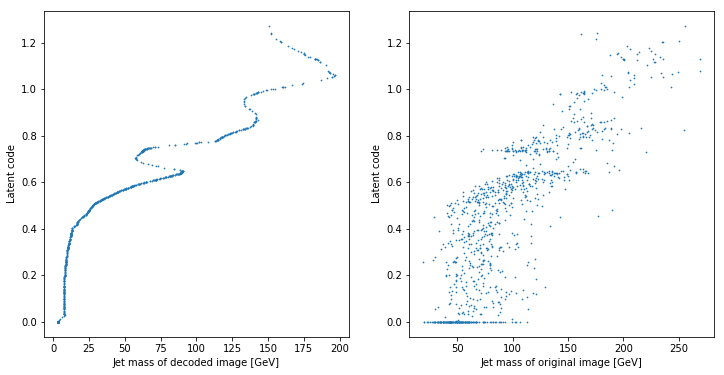

In [58]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.scatter(jet_masses(reconstructions[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of decoded image [GeV]')
plt.ylabel('Latent code')
plt.subplot(1,2,2)
plt.scatter(jet_masses(feed_pc[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of original image [GeV]')
plt.ylabel('Latent code')
plt.show()

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(jet_masses(reconstructions[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of decoded image [GeV]')
plt.ylabel('Latent code')
plt.show()

In [63]:
latent_codes

array([[0.00000000e+00],
       [0.00000000e+00],
       [5.81276476e-01],
       [1.26240134e+00],
       [3.47610474e-01],
       [1.75073600e+00],
       [1.39840186e-01],
       [1.92238939e+00],
       [3.10518295e-01],
       [1.17008245e+00],
       [3.96468550e-01],
       [7.54160583e-02],
       [4.76377696e-01],
       [0.00000000e+00],
       [2.68678188e-01],
       [6.89374804e-01],
       [0.00000000e+00],
       [8.80986333e-01],
       [0.00000000e+00],
       [1.44568950e-01],
       [2.33953893e-01],
       [3.62116545e-01],
       [0.00000000e+00],
       [7.80828893e-02],
       [1.66362613e-01],
       [2.27818418e+00],
       [2.96546161e-01],
       [0.00000000e+00],
       [2.14791155e+00],
       [9.05103624e-01],
       [0.00000000e+00],
       [1.44773412e+00],
       [1.10544348e+00],
       [6.39003396e-01],
       [2.02482671e-01],
       [0.00000000e+00],
       [8.25659990e-01],
       [7.49899149e-01],
       [8.32780004e-01],
       [1.34153813e-01],


In [74]:
numload = 10000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
feed_pc[0]

array([[ 0.017118  ,  0.19660918],
       [ 0.017118  ,  0.19660918],
       [ 0.017118  ,  0.19660918],
       ...,
       [-0.3880499 , -0.32016189],
       [ 0.01924656,  0.57144681],
       [ 0.63545814,  0.64884996]])

In [69]:
numpoints = len(jets[0])
Delta_Rs = np.linalg.norm(feed_pc,axis=2)
#    p_parr = np.sum(np.cos(Delta_Rs),axis=1)
np.sum(np.sin(jets[:,:,1]),axis=1)*600/1000

array([ 1.04154646, -1.01855432,  0.82381232,  2.8626084 ,  4.66926383,
        0.44145631, -0.78976928,  0.42520581, -0.56581046,  7.00944821,
       -0.0294308 , -1.07126786, -1.61526932, -0.52807492, -0.11218356,
       12.31053926, -1.94153188, -0.13629966,  1.2301602 , -1.22495414,
        1.48715351,  0.66155514, -0.25137587,  0.2585713 ,  0.59379215,
        0.61316492,  3.14910778,  0.09642428, 12.5186531 ,  0.95693838,
        1.4083551 ,  0.16460985, -0.01416972,  1.16919155, -0.13955238,
       -0.5423792 , -0.71587804,  0.51078518,  0.19862528, -0.3253633 ,
        6.62082248,  3.83881109, -0.72389678, -0.05940396,  3.14886234,
       -0.53045421,  0.09860626,  0.27655945,  0.23807206, -2.60423897,
        0.73574803,  0.37317332,  1.43749019, -0.45112478, -0.37274221,
        0.76862296,  3.13978595,  0.17130608, -0.19702835,  2.82923504,
        0.23081686, -0.2364088 ,  6.86463026,  1.0664655 ,  0.46326879,
        2.82499946,  0.27885064,  3.50456043,  2.10245745,  1.76

In [71]:
jets[:,:,0]

array([[ 0.01869681,  0.01869681,  0.01869681, ..., -0.23907139,
        -0.09400195, -0.65201326],
       [ 0.01031599,  0.01031599,  0.01031599, ...,  0.03088808,
         0.28167166,  0.82886674],
       [ 0.00961767,  0.00961767,  0.00961767, ...,  0.17601627,
        -0.60450113, -0.11882481],
       ...,
       [ 0.00723219,  0.00723219,  0.00723219, ...,  0.24995147,
         0.08002635, -0.34747694],
       [ 0.03372887,  0.03372887,  0.03372887, ...,  0.01355405,
         0.27136203,  0.16863137],
       [ 0.01648945,  0.01648945,  0.01648945, ...,  0.48698032,
         0.45907187,  0.58905874]])

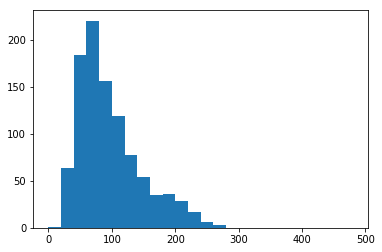

In [32]:
plt.hist(jet_masses(feed_pc), bins=np.arange(0,500,20))
plt.show()

In [42]:
jets = feed_pc
numpoints = len(jets[0])
Delta_Rs = np.linalg.norm(feed_pc,axis=2)
p_parr = np.sum(np.cos(Delta_Rs))
masses = np.sqrt(numpoints**2 - np.power(p_parr,2))*p_norm/numpoints

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [44]:
p_parr

96376.95345754223

In [60]:
np.cos(3.14)

-0.9999987317275395

In [102]:
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
#reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

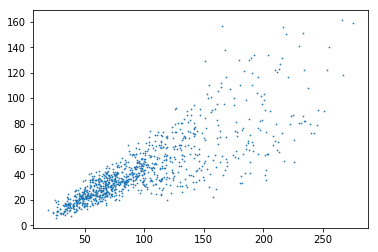

In [34]:
jet_masses(feed_pc[(latent_codes ==0.).flatten()])

array([ 35.28688225,  93.1821818 ,  68.674639  ,  66.82980052,
        74.14441173,  34.51399374,  69.14875579,  36.95418762,
        58.10141722,  35.03645862,  59.17256632,  46.93591623,
        65.7136201 ,  58.5225264 ,  49.73832894,  41.92313558,
        81.62550544,  81.31715223,  61.86501389,  70.09262545,
        55.00411739,  50.09787022,  56.01598295,  41.08508213,
        37.45209645,  26.12286477,  46.64123251,  33.62808724,
        76.62201858,  59.6882946 ,  97.54313234,  61.19816435,
        27.00050637,  52.88769576,  93.3634272 ,  69.40321466,
        32.31190283,  47.50241584,  80.27918911,  80.08367439,
        86.4246068 ,  59.84014424,  73.06503657,  35.90446185,
        70.4502928 ,  52.35135732,  62.28219444,  27.45181723,
        56.91367661,  37.44571713,  43.88163728,  56.53454517,
        91.66736612,  48.45572223,  55.14218424,  26.93894511,
        59.53523344,  90.1539713 ,  43.64649611,  49.89533825,
        65.84580757,  42.11258539,  97.3171227 ,  45.04

In [83]:
latent_codes[latent_codes ==0.][0]

0.0

In [85]:
(latent_codes ==0.)

array([[ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [